# Assignment 5 - Reinforcement Learning

## *Allison Young*
Netid:  *ary13*

###### Credit/Classmate Help Disclosure:
I completed questions one and two on my own prior to getting support from a classmate. With scheduling conflicts for office hours last week, I received support from classmates on question 3. However, I also wound up re-doing question 2 so the concepts would match and work together, and because I was unsuccessful in fixing the bugs for my original work. 

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [1]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)
    
print("cell has run")

cell has run


Here's an example of how it works to get you started:

In [37]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
#s0 = game.deal()
#print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
#s1 = game.step(1)
#print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

#The output summarizes the game status:
            
 #           ((15, 3, False), 0, False)
            
  #          The first tuple (15, 3, False), is the agent's observation of the
   #         state of the game as described above.
    #        The second value (0) indicates the rewards
     #       The third value (False) indicates whether the game is finished
    # The first value is the sum of cards in your hand (14 in this case)
       #     The second is the visible card in the dealer's hand 
        
# game 1
s0= game.deal()
print(s0)
#sum me = 12
#visible card = 10
s1 = game.step(1)
print(s1)

(17, 4, True)
((17, 4, False), 0, False)


In [63]:
game = Blackjack()
# Deal the cards:
#deal
s0= game.deal()
print(s0)

(12, 7, False)


In [65]:
#Hit
s1 = game.step(1)
print(s1)

((26, 7, False), -1, True)


In [62]:
s2=game.step(2)
print(s2)

((17, 1, False), -1.0, True)


**10**<br>
19,(2) -1 <br> 
20,(10) -1 <br>
24,(10), -1 <br>
15, (7), -1 <br>
21,(10), 1 <br>
23,(10), -1 <br>
18, (10), -1 <br>
21, (10), 1 <br>
19, (6), -1 <br>
23, (1), -1 <br>

**20**<br>
20, (6), 1 <br>
18, (10),1 <br>
25,(10), -1 <br>
20, (10),0 <br>
17, (10), 0 <br>
19, (10), 1 <br>
21, (9), 1 <br>
17, (8), -1 <br>
18, (10), 1 <br>
17, (3),1 <br>
<br>
**30**<br>
21, (6), 0 <br>
((19, 6, True), 1.0, True) <br>
((20, 4, False), 1.0, True) <br>
((20, 9, False), 1.0, True) <br>
((18, 9, False), -1.0, True) <br>
((18, 5, False), -1.0, True) <br>
((20, 2, False), 0.0, True) <br>
((22, 8, False), -1, True) <br>
((20, 10, True), 1.0, True) <br>
((18, 10, False), -1.0, True) <br>

**40**<br>
((20, 8, False), 1.0, True) <br>
((22, 9, False), -1, True) <br>
((26, 10, False), -1.0, True) <br>
((26, 4, False), -1, True) <br>
((20, 7, True), 1.0, True) <br>
((23, 5, False), -1, True) <br>
((24, 7, False), -1, True) <br>
((19, 7, True), 1.0, True) <br>
((24, 2, False), -1, True) <br>
((20, 10, False), -1.0, True) <br>

**50**<br>
((16, 3, False), 1.0, True) <br>
((20, 10, True), 0.0, True) <br>
((21, 10, False), 1.0, True) <br>
((17, 7, False), -1.0, True) <br>
((20, 10, True), -1.0, True) <br>
((20, 6, False), 1.0, True) <br>
((20, 10, True), 0.0, True) <br>
((22, 4, False), -1, True) <br>
((17, 1, False), -1.0, True) <br>
((26, 7, False), -1, True) <br>























**ANSWER**

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

### Monte Carlo Policy Evaluation 

#### Running 10k Simulation

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

# The original Policy
def originalPol(state):
    # a state includes the sum of players cards, dealers visible and a usuable ace boolean
    hand,_,_ = state
    
    # Hit if the players cards equal less than 20
    if hand < 20:
        return 1
    # if the player's cards are 20 or 21 stay
    else:
        return 0
    
# Prediction Fxn 

def countNreward(game, policy, episodes):

    ##### Initialize data structures before simulation
    
    # Dictionary to hold the stateValues as they are visited
    stateVals = defaultdict(float)
    # Dictionary to hold the returns for each state
    returns = defaultdict(float)
    # Dictionary to hold when each state is returned
    count = defaultdict(float)
    # For saving average reward per episode
    avgrperep = []
    
    # counters for episodes and rewards
    total_reward = 0
    total_episodes = 0
    
    # Simulation
    for episode_num in range(1, episodes+1):

        # Start a new game
        current_state = game.deal()

        # each episode is one hand til completion 
        episode = []
        
        counter = 0
        while True:

            # decide whether to hit or stay based on the player's current hand
            action = policy(current_state)

            # update the game with the action based on the policy
            next_state,reward,game_over = game.step(action)
            
            # save the current state and the associated award with that state
            episode.append((current_state, reward))

            # check to see if the game ended
            if game_over:
                total_reward += reward # if the game ended add that episodes reward to the total reward counter
                break

            # if not then continue playing
            current_state = next_state
        
        # Update the counter for total episodes
        total_episodes += 1
        
        # calculate the average reward and save it
        avgrperep.append(total_reward/float(total_episodes))

        # For each state appearing in the episode:
        for i in range(len(episode)):

            # Extract info from entry
            state, reward = episode[i]

            # G = return following the first occurrence of s
            #   Sum all rewards from here to end
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append G to return list
            returns[state] += G
            # Update so we can average reward over # of visits to state
            count[state] += 1

            # V[s] = average(Returns[s])
            stateVals[state] = returns[state]/count[state]
        
    return stateVals, avgrperep

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print("Starting eps.\n")

print("Starting 10k eps.\n")

Vals10k, avgR10k = countNreward(bjack_game, originalPol, 10000)

print("10k eps complete.\n")

print("Cell has run")




Starting eps.

Starting 10k eps.

10k eps complete.

Cell has run


#### Running 500k Simulations

In [14]:
## 500 k

plt.show()
print("Starting 500k eps.\n")
Vals500k, avgR500k = countNreward(bjack_game, originalPol, 500000)
print("500k eps complete.\n")

print("Cell has run")


Starting 500k eps.

500k eps complete.

Cell has run


### Simulation Plots for 10k and 500k

#### Plotting 10k Simulations

Plotting. 
 


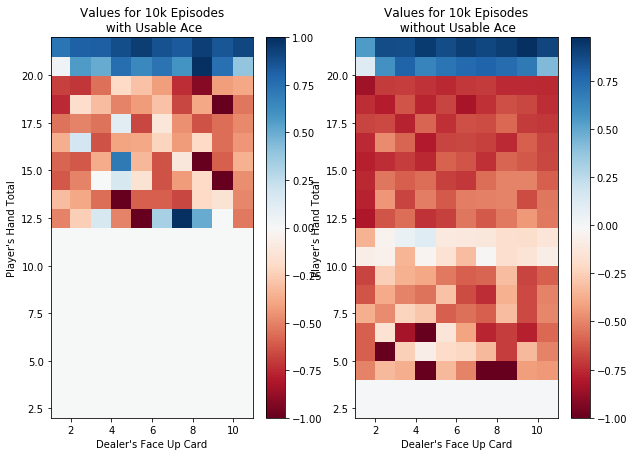

In [15]:
# 10k Plots
print("Plotting. \n ")

# Dealer's card shown
x = np.arange(1, 12, 1)
# Player's hand
y = np.arange(2, 23, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# the statevalues when there is a usuable ace
Ace10K = np.array([Vals10k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Ace10K = Ace10K.reshape(X.shape)

# the statevalues when there is a unusuable ace
NAce10k = np.array([Vals10k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
NAce10K = NAce10k.reshape(X.shape)

plt.figure(figsize = (10,7))

# Plotting an usuable ace
plt.subplot(1,2,1)
plt.title("Values for 10k Episodes\n with Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Player's Hand Total")
plt.pcolor(X,Y,Ace10K, cmap='RdBu')
plt.colorbar()

# Plotting an unusable ace
plt.subplot(1,2,2)
plt.title("Values for 10k Episodes\n without Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Player's Hand Total")
plt.pcolor(X,Y,NAce10K, cmap='RdBu')
plt.colorbar()





#### Plotting 500k Simulation

Plotting.



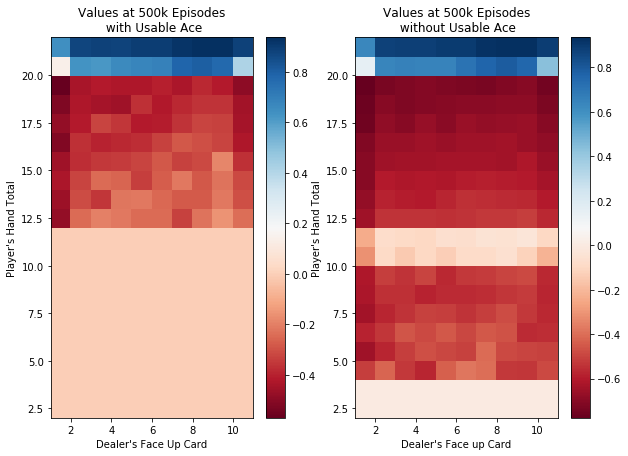

Cell has run.


In [16]:

print("Plotting.\n")

# 50K Plots

# the statevalues when there is a usuable ace
Ace500K= np.array([Vals500k[(y,x,True)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])
Ace500K = Ace500K.reshape(X.shape)

# The statevalues when there is an unusable ace
NAce500k = np.array([Vals500k[(y,x,False)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])
NAce500k = NAce500k.reshape(X.shape)

plt.figure(figsize = (10,7))

# Plotting an usuable ace
plt.subplot(1,2,1)
plt.title("Values at 500k Episodes\n with Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Player's Hand Total")
plt.pcolor(X, Y, Ace500K, cmap = 'RdBu')
plt.colorbar()

# Plotting an unusable ace
plt.subplot(1,2,2)
plt.title("Values at 500k Episodes\n without Usable Ace")
plt.xlabel("Dealer's Face up Card")
plt.ylabel("Player's Hand Total")
plt.pcolor(X, Y, NAce500k, cmap = 'RdBu')
plt.colorbar()

plt.show()

print("Cell has run.")

### Average reward per episode vs the number of episodes.

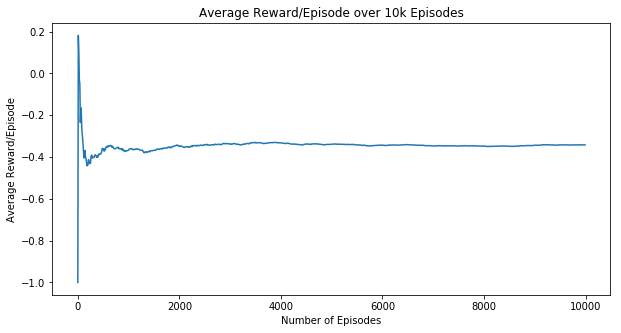

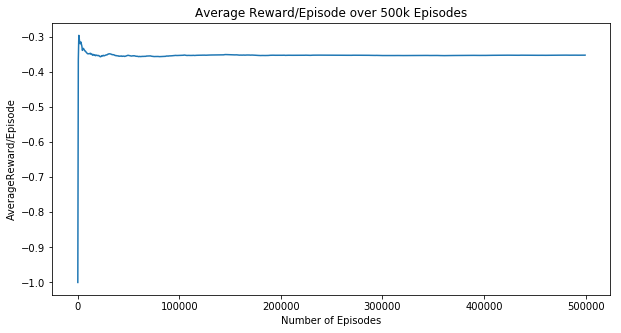

Average Reward for 10k -0.3773
Average Reward for 500k -0.3533


In [42]:
# Average reward for 10K Episodes
plt.figure(figsize=(10, 5))
plt.title("Average Reward/Episode over 10k Episodes")
plt.ylabel("Average Reward/Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0, len(avgReward10k),10), [avgReward10k[i] for i in range(0,len(avgReward10k), 10)])
plt.show()

# Average reward for 10K Episodes
plt.figure(figsize = (10, 5))
plt.title("Average Reward/Episode over 500k Episodes")
plt.ylabel("AverageReward/Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0,len(avgR500k),500), [avgR500k[i] for i in range(0,len(avgR500k), 500)])
plt.show()

overall10k = np.sum(np.array(avgR10k))/float(len(avgR10k))
overall500k = np.sum(np.array(avgR500k))/float(len(avgR500k))
print("Avg Reward for 10k {:.4f}".format(overall10k))
print("Avg Reward for 500k {:.4f}".format(overall500k))

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

In [41]:
from collections import defaultdict
import matplotlib.pyplot as plt
import random


# Define the policy function we will use
def originalPolC(policy, state, epsilon):
      
    # determine the best policy in the state.
    bestAct = policy[state]
    otherAct = 0 if bestAct == 1 else 1
    
    # Generate a random number in [0,1]
    num = random.uniform(0, 1)
    # check for (1-epsilon) case where we choose to EXPLORE
    if num >= epsilon:
        return otherAct
    # Most of the time choose to EXPLOIT
    else:
        return bestAct
    
def countNrewardC(game, policy, iterations):

    # A Dictionary to hold action value pairs
    actionPair = defaultdict(float)
    
    # A Dictionary to hold the returns for each action value pairs
    returns2 = defaultdict(float)
    
    # A Dictionary to store the number of times the state,action was taken
    count2 = defaultdict(float)
    
    # A Dictionary to hold the policy for each possible state
    Policy = defaultdict(float)
    
    # Array for saving average reward per episode
    average_reward_per_episode = []
    
    # array for the running average reward
    running_overall_average_reward = []
    
    # counters for the total reward and episodes
    total_reward = 0
    episode_counter = 0
    
    for it in range(1, iterations+1):

        # Start the game and set the current state
        current_state = game.deal()

        # Array to hold all of the episodes
        episode = []
        
        # Counters to hold the total rewards 
        total_episode_reward = 0
        counter = 0
        
        while True:

            # Determine action based on the current policy function
            N_0 = 100.
            N_st = count2[(current_state,1)] + count2[(current_state,0)]
            eps = 1- N_0/(N_0 + N_st)
            action = policy(Policy, current_state, eps)

            # Take the next step based on the best action for that state
            next_state, reward, game_over = game.step(action)

            # Update counters for average reward/episode
            total_episode_reward += reward
            counter += 1
            
            # Save the state, reward, and action for the episode
            episode.append((current_state, reward, action))

            # if the game is over update the total reward
            if game_over:
                total_reward += reward
                break

            # else go to the next state
            current_state = next_state

        # Save average reward for this episode
        average_reward_per_episode.append(total_episode_reward/float(counter))
        episode_counter += 1
        running_overall_average_reward.append(total_reward/float(episode_counter))       
    
        # For each state,action pair appearing in the episode:
        for i in range(len(episode)):

            state,reward,action = episode[i]

            # G is the return following the first time to that state 
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append episodic return G to Returns
            returns2[(state,action)] += G
            # update Returns_cnt in order to average reward over all visits to that state
            count2[(state,action)] += 1

            # Update the action pair based on the average returns from that state
            actionPair[(state,action)] = returns2[(state,action)]/count2[(state,action)]
        
        # For each state in the episode
        for i in range(len(episode)):
            state,_,_ = episode[i]
            # Find the best action for that state. 
            a_hit = actionPair[(state,1)]
            a_stay = actionPair[(state,0)]
            a_best = 1 if a_hit > a_stay else 0
            Policy[state] = a_best
            
    return actionPair, Policy, average_reward_per_episode, running_overall_average_reward

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print("Starting eps.\n")

# Conduct 2 Million iterations of the greedy policy for results.
actionPair, policy, avgR, runningAvg = countNrewardC(bjack_game, originalPolC, 5000000)

print("Done.")

Starting eps.

Done.


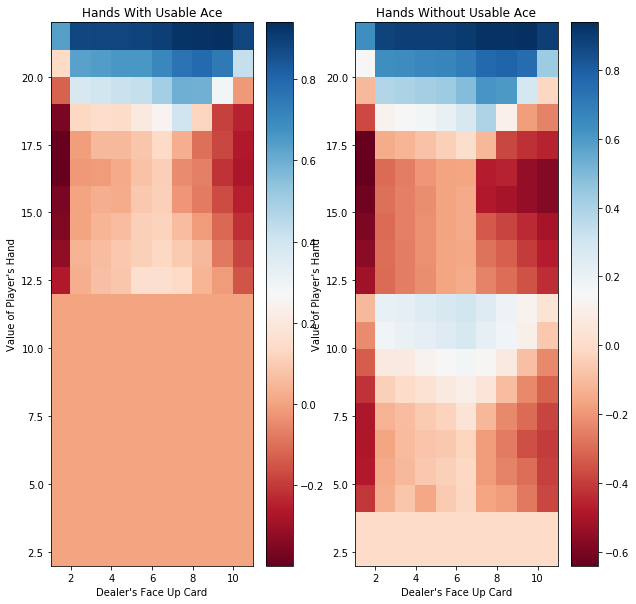

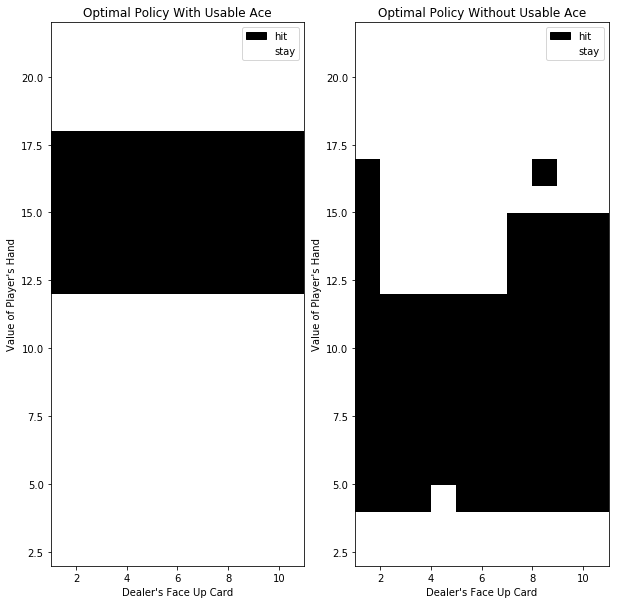

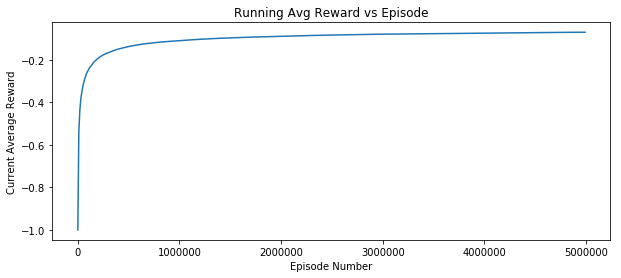

Overall Average Reward: -0.0593 


In [48]:
import numpy as np
import matplotlib.patches as mpatches

# Dealers card showing
x = np.arange(1, 12, 1)
# Player's hand total 
y = np.arange(2, 23, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# Grab the value in V for each x,y coordinate for 'usable_Ace = True'
q_usable = np.maximum(np.array([actionPair[((y, x, True), 0)] for (x, y) in zip(np.ravel(X), np.ravel(Y))]), 
                      np.array([actionPair[((y, x, True), 1)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_usable = q_usable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = False'
q_unusable = np.maximum(np.array([actionPair[((y, x, False), 0)] for (x, y) in zip(np.ravel(X), np.ravel(Y))]), 
                        np.array([actionPair[((y, x, False), 1)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_unusable = q_unusable.reshape(X.shape)

# Policy fxn for states with unusable ace
pol_unusable = np.array([originalPol2(policy, (y, x, False), 1.1) for (x, y) in zip(np.ravel(X), np.ravel(Y))])
Policy_unusable = pol_unusable.reshape(X.shape)

# Policy fxn for states with usable ace
pol_usable = np.array([originalPol2(policy, (y, x, True), 1.1) for (x, y) in zip(np.ravel(X), np.ravel(Y))])
Policy_usable = pol_usable.reshape(X.shape)


plt.figure(figsize=(10,10))

# plot the player's hand with usuable aces
plt.subplot(1,2,1)
plt.title("Hands With Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Q_usable, cmap = 'RdBu')
plt.colorbar()

# plot the players hand with unusuable aces
plt.subplot(1,2,2)
plt.title("Hands Without Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Q_unusable, cmap = 'RdBu')
plt.colorbar()
plt.show

plt.figure(figsize=(10,10))
# plot the optimal policy with usuable aces
plt.subplot(1,2,1)
plt.title("Optimal Policy With Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Policy_usable, cmap = 'Greys')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')
plt.legend(handles = [legend_hit,legend_stay])

# plot the optimal policy with unusuable aces
plt.subplot(1,2,2)
plt.title("Optimal Policy Without Usable Ace")
plt.xlabel("Dealer's Face Up Card")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Policy_unusable, cmap = 'Greys')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')

plt.legend(handles = [legend_hit,legend_stay])

plt.figure(figsize=(10,4))
plt.title("Running Avg Reward vs Episode")
plt.ylabel("Current Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0,len(runningAvg),10000), [runningAvg[i] for i in range(0,len(runningAvg),10000)])
#plt.plot(running_avg)
plt.show()


plt.show()

# Calculate overall average rewards for 10k and 500k runs
# for 10k
overallAvgR = np.sum(np.array(avgR))/float(len(avgR))
print("Overall Average Reward: {:.4f} ".format(overallAvgR))



## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

The net wins for the human experiment was -11, which is -.22 reward per game. The Monte Carlo Policy Evaluations results in a an Average Reward for 10k of -0.3773. The Average Reward for infinite games is -0.059. Therefore, the house definitely always wins! The optimal policy from question 3 clearly berforms best. The full knowledge of MDP would not necessarily have created a better policy, because with infinate time, the policy converges to the best solution. 